In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('random_batch_18_nov_2020.csv')

# Display the head
df.head()

,repo_name,commit,message,Is_Refactor,Is_Perfective,Is_Adaptive,Is_Corrective,Justification,Comment,Certain,Sampling,Is_English,Is_Abstraction,Is_Performance,Is_Positive_Sentiment,Is_Negative_Sentiment,Is_Security,Is_Swearing
0,pymor/dune-gdt,b0c1b7037681ded5b3409fdbb9f18902684e92d9,[pylicense] add .tpl to config bump copyright ...,False,True,False,FALSE,"add, bump copyright",NaN,NaN,random_batch_18_nov_2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,wso2/carbon-analytics,ddcea4897ac24c0f71469cc5ed4846dcfe23585f,Added missing iterator\n,False,False,False,TRUE,add missing,NaN,NaN,random_batch_18_nov_2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,root-mirror/root,e41c550e9371bc246a66df25edd02fec109d67b0,win32gdk source files.\n\n\ngit-svn-id: acec3f...,False,False,False,FALSE,NaN,NaN,FALSE,random_batch_18_nov_2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,yuanming-hu/taichi,1bd17f6f1507a07b1a8896511642f72eac19843b,removed all return values of runtime initializ...,False,False,False,FALSE,removed,NaN,NaN,random_batch_18_nov_2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,otwcode/otwarchive,f96a19672775cc67940c99e5a0a3043b97a1ee29,Merge pull request #988 from tuff-ghost/issue_...,True,True,False,FALSE,rewrite,NaN,NaN,random_batch_18_nov_2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Preprocessing

# Columns to drop:
    # repo_name and commit:
        # Reason: They are just identifiers and don’t provide meaningful information
    # Is_Abstraction, Is_Performance, Is_Positive_Sentiment, Is_Negative_Sentiment, Is_Security, Is_Swearing:
        # Reason: They are secondary attributes, sparsely populated and likely not very useful
    # Comment, Certain, Justification, Is_English, Sampling:
        # Reason: They are not useful and most of their rows are missing 

# Columns to keep:
    # message
        # Reason: for obvious reasons
    # Is_Refactor, Is_Perfective, Is_Adaptive, Is_Corrective:
        # Reason: They are the primary targets

label_columns = ['Is_Refactor', 'Is_Perfective', 'Is_Adaptive', 'Is_Corrective']

columns_to_drop = ['repo_name', 'commit', 'Is_Abstraction', 'Is_Performance', 'Is_Positive_Sentiment', 'Is_Negative_Sentiment', 'Is_Security', 'Is_Swearing', 'Comment', 'Certain', 'Justification', 'Is_English', 'Sampling']

df = df.drop(columns_to_drop, axis=1)
df = df.dropna(axis=0, subset=['message'])

# Lowercasing: Reducing redundancy in tokenized text
df['message'] = df['message'].str.lower()

# Removing duplicates.
df = df.drop_duplicates(subset=['message'])

# Convert True and False to 1 and 0, handle case differences and whitespace
for col in label_columns:
    df[col] = df[col].apply(lambda x: 1 if str(x).strip().lower() == 'true' 
                            else 0 if str(x).strip().lower() == 'false' 
                            else pd.NA)

# Confirm
df.head()

,message,Is_Refactor,Is_Perfective,Is_Adaptive,Is_Corrective
0,[pylicense] add .tpl to config bump copyright ...,0,1,0,0
1,added missing iterator\n,0,0,0,1
2,win32gdk source files.\n\n\ngit-svn-id: acec3f...,0,0,0,0
3,removed all return values of runtime initializ...,0,0,0,0
4,merge pull request #988 from tuff-ghost/issue_...,1,1,0,0


In [5]:
# Separating labeled and unlabeled data
labeled_df = df.dropna(subset=label_columns, how='all')  # Get rows with at least one label
unlabeled_df = df[df[label_columns].isna().all(axis=1)]  # Rows with no labels

# Displaying the lengths of the whole dataset and also the labeled and unlabeled data.
print(f"Total rows: {len(df)}")
print(f"Labeled rows: {len(labeled_df)}")
print(f"Unlabeled rows: {len(unlabeled_df)}")

Total rows: 4942
Labeled rows: 1391
Unlabeled rows: 3551


In [7]:
# Splitting the training and testing data
from sklearn.model_selection import train_test_split

# Split the data
train_df, test_df = train_test_split(labeled_df, test_size=0.15, random_state=42)

In [9]:
# Check for NaN values in the labeled data
print(train_df[label_columns].isna().sum())
print(test_df[label_columns].isna().sum())

Is_Refactor      3
Is_Perfective    4
Is_Adaptive      6
Is_Corrective    4
dtype: int64
Is_Refactor      0
Is_Perfective    0
Is_Adaptive      0
Is_Corrective    0
dtype: int64


In [11]:
# Fill the NaN values with zeroes
train_df[label_columns] = train_df[label_columns].fillna(0).astype(int)
test_df[label_columns] = test_df[label_columns].fillna(0).astype(int)

C:\Users\ahmet\AppData\Local\Temp\ipykernel_7772\226184742.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df[label_columns] = train_df[label_columns].fillna(0).astype(int)
C:\Users\ahmet\AppData\Local\Temp\ipykernel_7772\226184742.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df[label_columns] = test_df[label_columns].fillna(0).astype(int)


In [13]:
# Converting the data to the expected format by SimpleTransformers
train_df['labels'] = train_df[label_columns].values.tolist()
train_df = train_df[['message', 'labels']]
train_df.columns = ['text', 'labels']

test_df['labels'] = test_df[label_columns].values.tolist()
test_df = test_df[['message', 'labels']]
test_df.columns = ['text', 'labels']

In [15]:
# Model training
from simpletransformers.classification import MultiLabelClassificationModel

model = MultiLabelClassificationModel(
    "distilbert",           # Pre-trained model type
    "distilbert-base-uncased",  # Pre-trained model name
    num_labels=4,           # Number of target labels
    args={
        "learning_rate": 2e-5,
        "num_train_epochs": 4,
        "max_seq_length": 512,
        "train_batch_size": 8,
        "eval_batch_size": 8,
        "reprocess_input_data": True,
        "overwrite_output_dir": True,
    },
    use_cuda=True         
)

# Train the model
model.train_model(train_df)

Some weights of DistilBertForMultiLabelSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

C:\Python311\Lib\site-packages\simpletransformers\classification\classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 4:   0%|          | 0/148 [00:00<?, ?it/s]

C:\Python311\Lib\site-packages\simpletransformers\classification\classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 4:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/148 [00:00<?, ?it/s]

(592, 0.40396170358400085)

In [25]:
# Threshold tuning
from sklearn.metrics import f1_score

best_threshold = 0.5
best_f1 = 0

# Iterate through potential thresholds
for threshold in np.arange(0.1, 1.0, 0.1):
    y_pred = (np.array(model_outputs) >= threshold).astype(int)
    f1 = f1_score(y_true, y_pred, average="weighted")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1}")

Best Threshold: 0.30000000000000004, Best F1-Score: 0.5815634802712936


In [27]:
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss
import numpy as np

def metrics(y_true, y_pred_logits):
    # Threshold the logits to get binary predictions
    threshold = 0.3
    y_pred = (y_pred_logits >= threshold).astype(int)

    # Calculate metrics
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    hamming = hamming_loss(y_true, y_pred)

    metrics_dict = {
        "F1-Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Hamming Loss": hamming
    }

    # Print the metrics
    print("Metrics:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value:.4f}")

    return metrics_dict

result, model_outputs, wrong_predictions = model.eval_model(
    test_df,
    eval_fn=metrics  
)

0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/27 [00:00<?, ?it/s]

C:\Python311\Lib\site-packages\simpletransformers\classification\classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Metrics:
F1-Score: 0.5816
Precision: 0.5638
Recall: 0.6094
Hamming Loss: 0.2117


In [29]:
threshold = 0.3

# Convert model outputs to binary predictions
y_pred = (np.array(model_outputs) >= threshold).astype(int)
y_true = np.array(test_df['labels'].tolist())

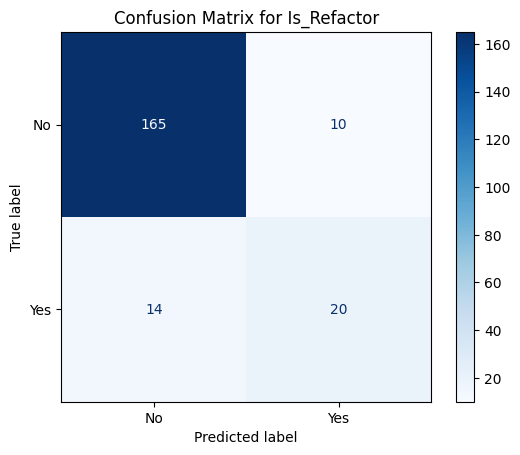

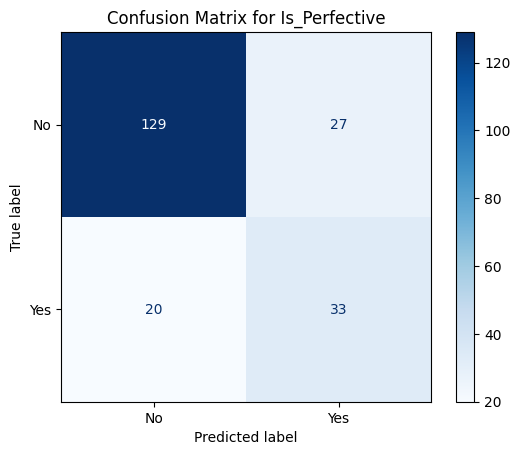

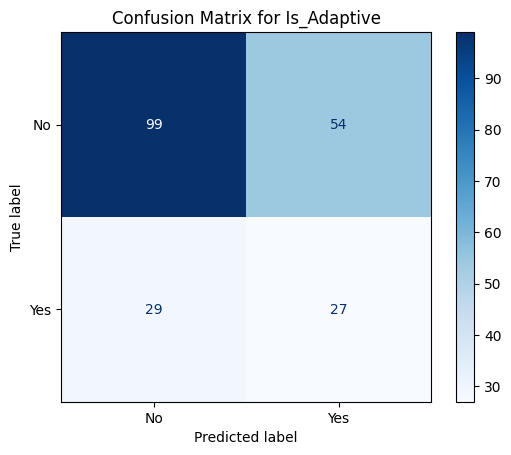

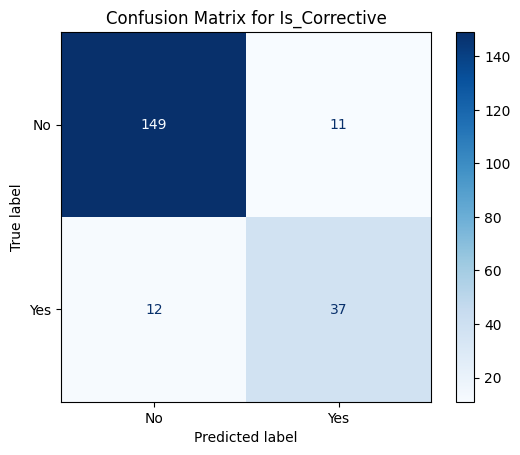

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Confusion Matrix
for i, label in enumerate(label_columns):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {label}")
    plt.show()

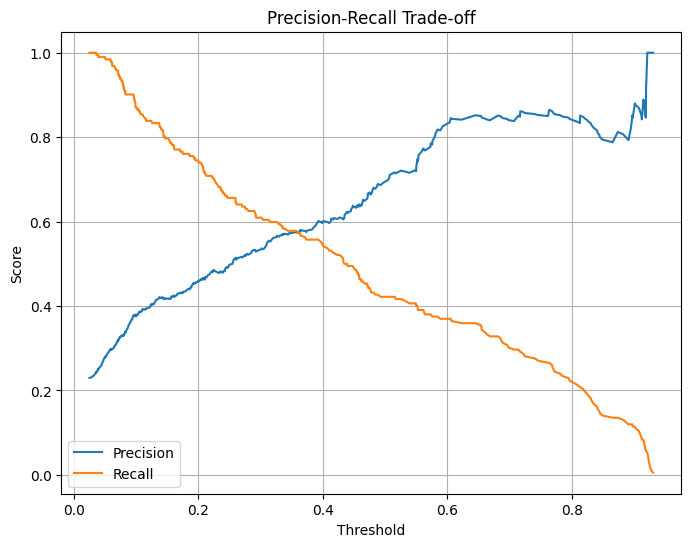

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

y_true_flat = y_true.ravel()
model_outputs_flat = np.array(model_outputs).ravel()

# Calculate precision and recall at different thresholds
precision, recall, thresholds = precision_recall_curve(y_true_flat, model_outputs_flat)

# Plot Precision vs Recall
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Trade-off')
plt.legend()
plt.grid()
plt.show()
